In [29]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LIBRARIES
# import rasterio
# import contextily as cx
import geopandas as gpd
import pandas as pd


# PREFERENCES
pd.set_option('display.max_columns', 500)
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

Define our Scikit-Learn Compliant Class so we can implement validation schemes within. Only two methods required: predict() and fit()

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred


Define function to get values from Random Forest

In [3]:
def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    print(perf_dir + modelfiles[0])
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        print(perf_dir + modelfiles[ii])
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)

    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in perf.columns if fitmet in col]

    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)


    testvalues = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    msetest = list()
    msetrain = list()
    msemeta = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)

            # print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")


    return camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance

In [4]:
rfargs =  {"n_estimators": 15}
camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)

c:\Users\franc\anaconda3\envs\SIMain\lib\site-packages\geopandas\geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SIMain\lib\site-packages\geopandas\geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\CFE.csv
C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\LSTM.csv


In [18]:
# THIS IS THE BEST PREDICTED MODEL
# CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
# BEST PRED MODEL = BPM
bpm_idx = np.argmax(testvalues, axis=1)
bpm_perf = testvalues[np.arange(testvalues.shape[0]), bpm_idx]

# THIS IS THE BEST ACTUAL MODEL
# CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
# BEST ACTUAL MODEL = BAM
target_perf = target.to_numpy()
bam_idx = np.argmax(target_perf, axis=1)
bam_perf = target_perf[np.arange(testvalues.shape[0]), bam_idx]

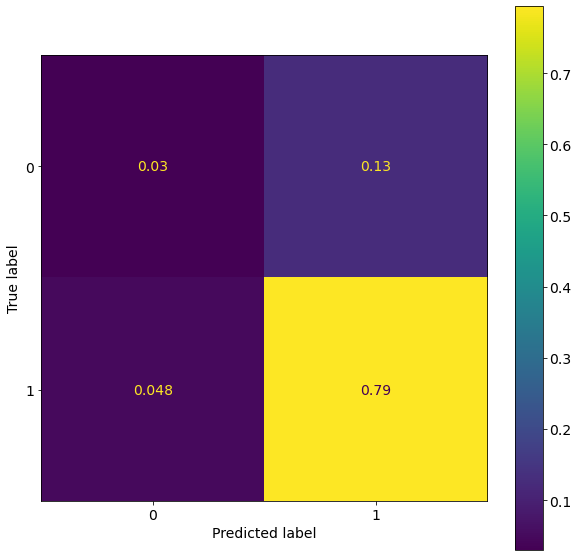

In [36]:
# PLOT CONFUSION MATRIX
ConfusionMatrixDisplay.from_predictions(bam_idx, bpm_idx, normalize='all')

(array([21., 13.,  8.,  8.,  8.,  6.,  7.,  6.,  3.,  1.,  1.,  1.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([3.51420000e-04, 2.29436590e-02, 4.55358981e-02, 6.81281371e-02,
        9.07203762e-02, 1.13312615e-01, 1.35904854e-01, 1.58497093e-01,
        1.81089332e-01, 2.03681571e-01, 2.26273811e-01, 2.48866050e-01,
        2.71458289e-01, 2.94050528e-01, 3.16642767e-01, 3.39235006e-01,
        3.61827245e-01, 3.84419484e-01, 4.07011723e-01, 4.29603962e-01,
        4.52196201e-01]),
 <BarContainer object of 20 artists>)

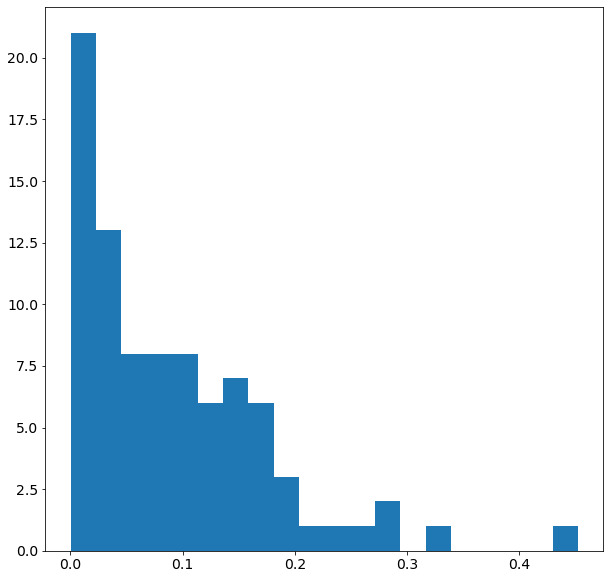

In [35]:
# IN SAMPLES THAT ARE NOT CORRECTLY CLASSIFIED (ie, bpm_idx != bam_idx)
# HOW FAR OFF ARE THE TWO ACTUAL PERFORMANCES?
wrong_model = np.where(bpm_idx != bam_idx, True, False)
wrong_model_perfdiff = np.abs(target_perf[wrong_model, 0] - target_perf[wrong_model, 1])
plt.hist(wrong_model_perfdiff, bins=20)

In [49]:
def ensemblePerf(perf, threshold=0.2):
    # TODO: CONSIDER DOING A MORE ROBUST THING WERE YOU CALCULATE THE DIFFERENCE
    # BETWEEN EACH PERFORMANCE AND THE MINIMUM OF THE ROW WITHOUT ITSELF
    # THEN, RUN A NP.WHERE TO ESTABLISH THAT IF BIGGER THAN THRESHOLD, SET TO NAN
    # AND CALCULATE THE NORMALIZED PERFORMANCE FROM THERE

    # RANGE OF EACH ROW
    rn = np.max(perf, axis=1) - np.min(perf, axis=1)
    
    # THIS IS THE BEST PREDICTED MODEL
    # CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
    # BEST PRED MODEL = BPM
    bpm_idx = np.argmax(perf, axis=1)
    bpm_perf = perf[np.arange(perf.shape[0]), bpm_idx]

    # CALCULATE THE VALUES FOR ENSEMBLING MODELS
    row_sums = perf.sum(axis=1)
    perf_norm = perf / row_sums[:, np.newaxis]
    ens_perf = np.sum(perf * perf_norm, axis=1)
    
    # CREATE OUTPUT STRUCTURE
    output = np.where(rn < threshold, ens_perf, bpm_perf)

    return output

In [53]:
cfe = testvalues[:, 0]
lstm = testvalues[:, 1]
bestpred = bpm_perf
ensemble = ensemblePerf(testvalues, threshold=0.2)
bestmodel = bam_perf

Text(0, 0.5, 'NNSE')

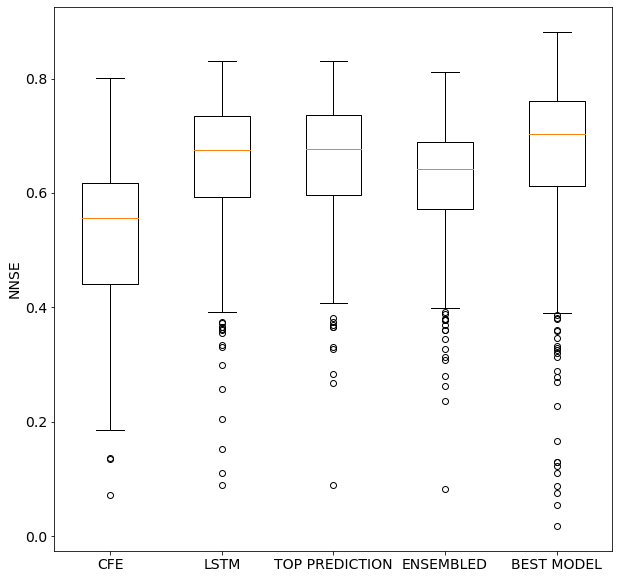

In [55]:
plt.boxplot([cfe, lstm, bestpred, ensemble, bestmodel], labels=["CFE", "LSTM", "TOP PREDICTION", "ENSEMBLED", "BEST MODEL"])
plt.ylabel("NNSE")